In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression  # Mudança aqui
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

/home/heart/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:

# Carregando o dataset
df = pd.read_csv("datasets/winequality-merged.csv")
print(df.head())

# Simulando a coluna 'color' (remova se já existir)
df['color'] = np.random.choice(['white', 'red'], size=len(df))
df['color'] = df['color'].map({'white': 0, 'red': 1})

# Explorando os dados
print(df.describe())
print(df.isnull().sum())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  color  
0      8.8        6  white  
1      9.5        6  white  

In [3]:
# Função para remover outliers usando IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df


# 1. Remover outliers
numeric_cols = df.drop(['quality', 'color'], axis=1).columns
df = remove_outliers(df, numeric_cols)

In [4]:
# 2. Análise de correlação para seleção de features
print("Correlação das features com 'quality':")
corr = df.corr()['quality'].sort_values(ascending=False)
print(corr)

# Selecionar features com correlação absoluta > 0.05
selected_features = corr[abs(corr) > 0.05].index.drop('quality')  # Exclui 'quality'
X = df[selected_features]
y = (df["quality"] >= 6).astype(int)

Correlação das features com 'quality':
quality                 1.000000
alcohol                 0.436178
pH                      0.053404
citric acid             0.041809
free sulfur dioxide     0.040577
color                   0.024321
sulphates               0.023871
residual sugar         -0.073696
fixed acidity          -0.089485
total sulfur dioxide   -0.118867
volatile acidity       -0.166279
chlorides              -0.266654
density                -0.315562
Name: quality, dtype: float64


In [5]:
# 3. Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Aplicar SMOTE para balanceamento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [6]:
# 5. Normalizar as features
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

In [7]:
# 6. Treinar Regressão Logística com regularização ajustada
model = LogisticRegression(max_iter=1000, C=1.0)  # C controla a regularização (menor C = mais regularização)
model.fit(X_train_res, y_train_res)

# 7. Previsões e probabilidades
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [9]:
# 8. Avaliação com limiar padrão (0.5)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'\nAcurácia (limiar 0.5): {accuracy:.2f}')
print("Matriz de Confusão (limiar 0.5):")
print(cm)
print(f'Precisão (classe "bom"): {precision:.2f}')
print(f'Revocação (classe "bom"): {recall:.2f}')
print(f'F1-Score (classe "bom"): {f1:.2f}')


Acurácia (limiar 0.5): 0.71
Matriz de Confusão (limiar 0.5):
[[197  63]
 [201 445]]
Precisão (classe "bom"): 0.88
Revocação (classe "bom"): 0.69
F1-Score (classe "bom"): 0.77


In [ ]:
# 9. Ajustar limiar para maximizar precisão 
threshold = 0.7
y_pred_adjusted = (y_prob >= threshold).astype(int)
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
cm_adjusted = confusion_matrix(y_test, y_pred_adjusted)
precision_adjusted = precision_score(y_test, y_pred_adjusted)
recall_adjusted = recall_score(y_test, y_pred_adjusted)
f1_adjusted = f1_score(y_test, y_pred_adjusted)
print(f'\nAcurácia (limiar 0.7): {accuracy_adjusted:.2f}')
print("Matriz de Confusão (limiar 0.7):")
print(cm_adjusted)
print(f'Precisão (classe "bom"): {precision_adjusted:.2f}')
print(f'Revocação (classe "bom"): {recall_adjusted:.2f}')
print(f'F1-Score (classe "bom"): {f1_adjusted:.2f}')


Acurácia (limiar 0.7): 0.58
Matriz de Confusão (limiar 0.7):
[[240  20]
 [356 290]]
Precisão (classe "bom"): 0.94
Revocação (classe "bom"): 0.45
F1-Score (classe "bom"): 0.61


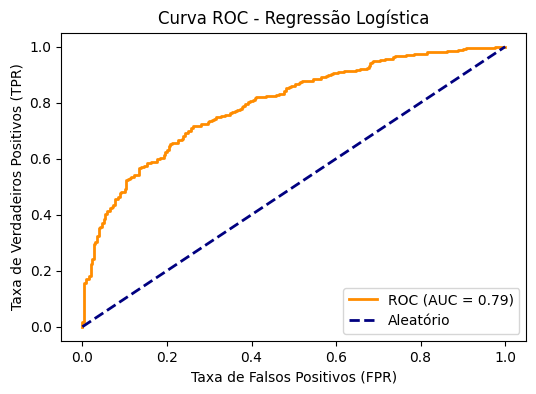

In [ ]:
# 10.Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Regressão Logística')
plt.legend(loc="lower right")
plt.show()

Acurácia média com CV: 0.73 (+/- 0.05)


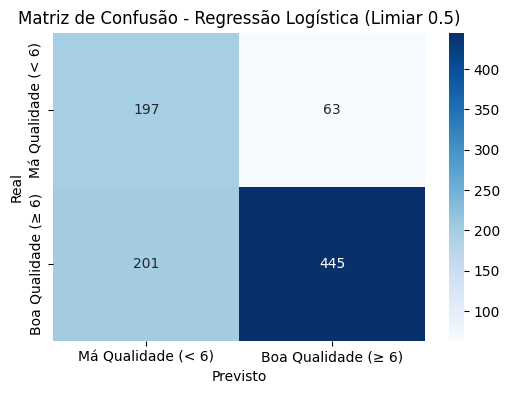

In [12]:
# 11. Validação Cruzada
scores = cross_val_score(LogisticRegression(max_iter=1000, C=1.0), scaler.fit_transform(X), y, cv=5, scoring='accuracy')
print(f'Acurácia média com CV: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})')

# 12. Visualização da Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Má Qualidade (< 6)", "Boa Qualidade (≥ 6)"], 
            yticklabels=["Má Qualidade (< 6)", "Boa Qualidade (≥ 6)"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Regressão Logística (Limiar 0.5)")
plt.show()

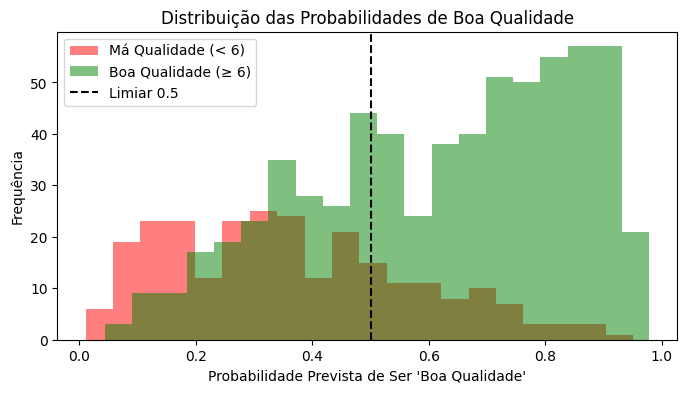

In [13]:
# 13. Distribuição das Probabilidades
plt.figure(figsize=(8, 4))
plt.hist(y_prob[y_test == 0], bins=20, alpha=0.5, label="Má Qualidade (< 6)", color="red")
plt.hist(y_prob[y_test == 1], bins=20, alpha=0.5, label="Boa Qualidade (≥ 6)", color="green")
plt.axvline(0.5, color='black', linestyle='--', label='Limiar 0.5')
plt.xlabel("Probabilidade Prevista de Ser 'Boa Qualidade'")
plt.ylabel("Frequência")
plt.title("Distribuição das Probabilidades de Boa Qualidade")
plt.legend()
plt.show()

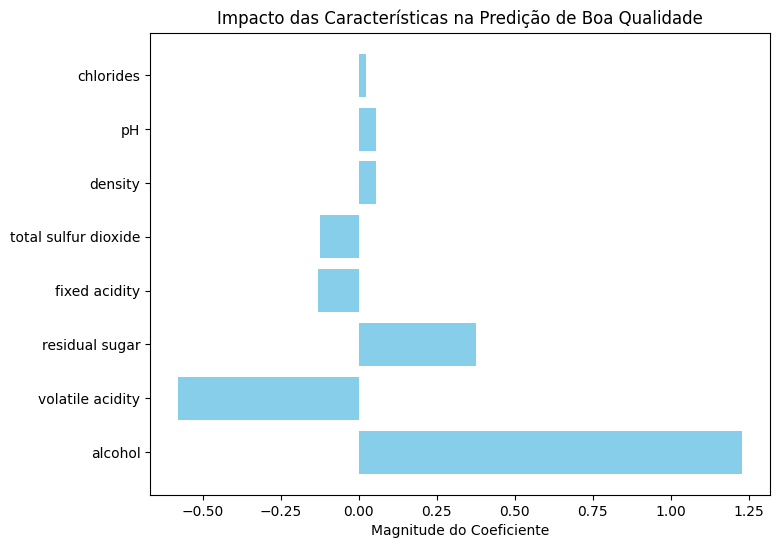

In [14]:
# 14. Importância das Características
feature_names = X.columns
coefs = model.coef_[0]
sorted_indices = np.argsort(np.abs(coefs))[::-1]
plt.figure(figsize=(8, 6))
plt.barh(feature_names[sorted_indices], coefs[sorted_indices], color="skyblue")
plt.xlabel("Magnitude do Coeficiente")
plt.title("Impacto das Características na Predição de Boa Qualidade")
plt.show()